# Проведения гипотезы с данными

---

Некоторые miRNA являются биомаркерами, связанными с прогрессией РПЖ, включая развитие метастазов в лимфатические узлы, и могут быть использованы для прогнозирования исходов заболевания.

---

Задачи:

1.Найти miRNA, дифференциально экспрессируемые при РПЖ (особенно при агрессивных формах).

2.Определить miRNA, коррелирующие с метастазированием в лимфатические узлы.

3.Подготовить список кандидатов для биоинформатического анализа.

In [ ]:
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import numpy as np

In [ ]:
# Installing lifelines if not already installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "lifelines"])

# Reading miRNA and clinical data
mirna_data = pd.read_csv('mirna.tsv', sep='\t', index_col='attrib_name')
clinical_data = pd.read_csv('clinical.tsv', sep='\t', index_col='attrib_name')

In [ ]:
# Transposing both datasets to have samples as rows and attributes/miRNAs as columns
mirna_data = mirna_data.T
clinical_data = clinical_data.T

# Selecting common samples (TCGA IDs) between miRNA and clinical data
common_samples = mirna_data.index.intersection(clinical_data.index)
mirna_data = mirna_data.loc[common_samples]
clinical_data = clinical_data.loc[common_samples]

In [ ]:
# Step 1: Data cleaning - Handle missing values and convert types
clinical_data['overall_survival'] = pd.to_numeric(clinical_data['overall_survival'], errors='coerce')
clinical_data['status'] = pd.to_numeric(clinical_data['status'], errors='coerce')
clinical_data['Tumor_purity'] = pd.to_numeric(clinical_data['Tumor_purity'], errors='coerce')

# Remove samples with missing values in key clinical columns
clinical_data = clinical_data.dropna(subset=['pathology_T_stage', 'Tumor_purity', 'overall_survival', 'status'])
# Update miRNA data to match cleaned clinical samples
mirna_data = mirna_data.loc[clinical_data.index]

In [ ]:
# Step 2: Remove miRNAs with excessive missing values (>50%)
mirna_data = mirna_data.dropna(thresh=len(mirna_data) * 0.5, axis=1)

In [ ]:
# Step 3: Remove low-variance miRNAs (noise filtering)
std_threshold = 0.1  # Minimum standard deviation for miRNAs
mirna_std = mirna_data.std()
mirna_data = mirna_data.loc[:, mirna_std > std_threshold]

In [ ]:
# Step 4: Check for anomalies in clinical data
# Ensure Tumor_purity is in [0, 1] and overall_survival is non-negative
clinical_data = clinical_data[(clinical_data['Tumor_purity'].between(0, 1)) & (clinical_data['overall_survival'] >= 0)]

# Update miRNA data again to match final clinical samples
mirna_data = mirna_data.loc[clinical_data.index]

# Selecting a few miRNAs for analysis (top 5 by variance)
selected_mirnas = mirna_data.var().nlargest(5).index
mirna_subset = mirna_data[selected_mirnas]

# Merging miRNA and clinical data
merged_data = pd.concat([mirna_subset, clinical_data[['pathology_T_stage', 'Tumor_purity', 'overall_survival', 'status']]], axis=1)

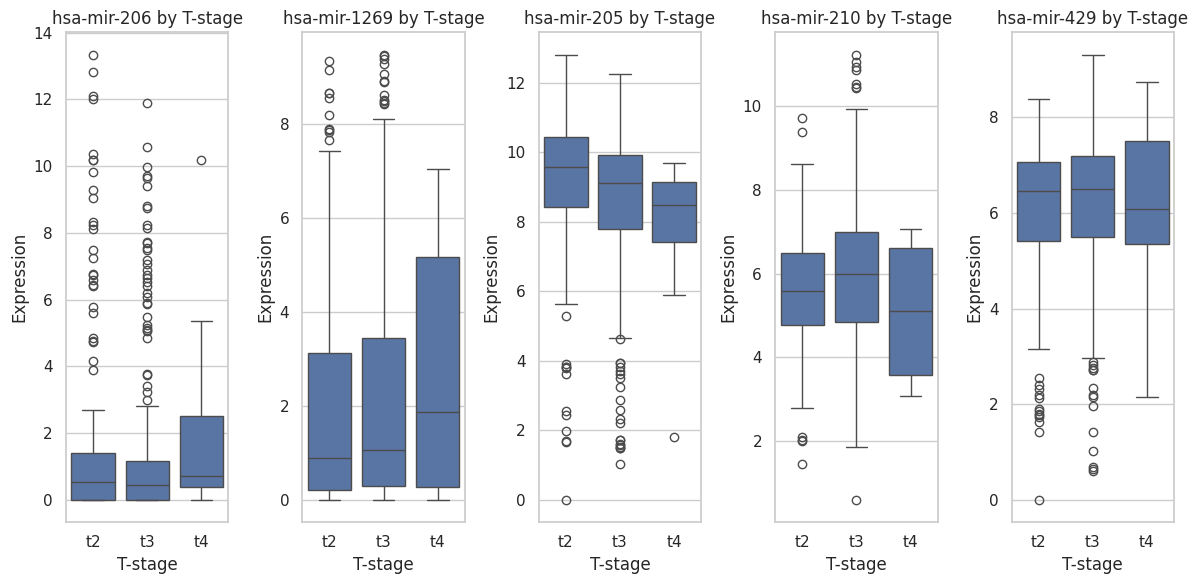

In [ ]:
# Plot 1: Boxplot of miRNA expression by T-stage
plt.figure(figsize=(12, 6))
for i, mirna in enumerate(selected_mirnas, 1):
    plt.subplot(1, len(selected_mirnas), i)
    sns.boxplot(x='pathology_T_stage', y=mirna, data=merged_data, order=['t2', 't3', 't4'])
    plt.title(f'{mirna} by T-stage')
    plt.xlabel('T-stage')
    plt.ylabel('Expression')
    plt.tight_layout()
plt.show()

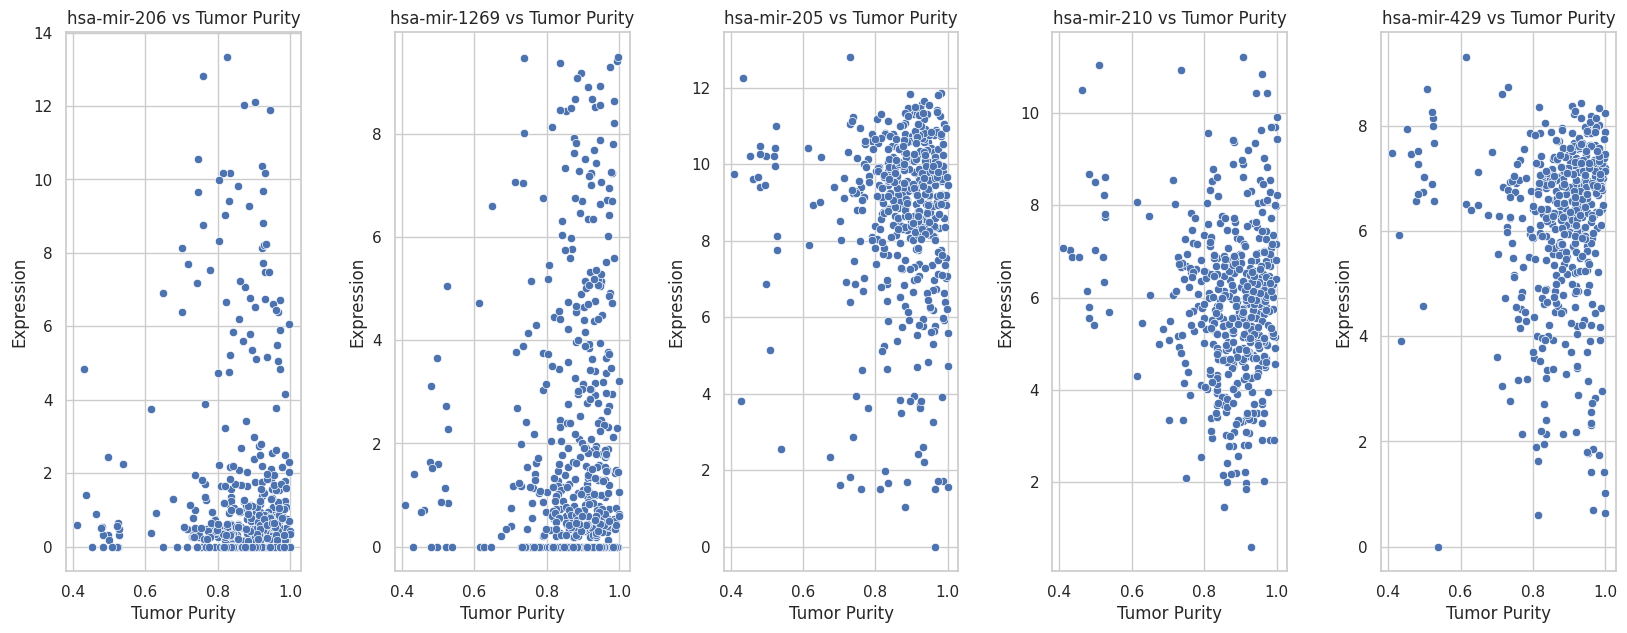

In [ ]:
# Plot 2: Scatter plot of miRNA expression vs Tumor purity
plt.figure(figsize=(20, 7))  # Можно чуть шире, если хочешь больше отступов

for i, mirna in enumerate(selected_mirnas, 1):
    plt.subplot(1, len(selected_mirnas), i)
    sns.scatterplot(x='Tumor_purity', y=mirna, data=merged_data)
    plt.title(f'{mirna} vs Tumor Purity')
    plt.xlabel('Tumor Purity')
    plt.ylabel('Expression')

# Добавляем расстояние между графиками
plt.subplots_adjust(wspace=0.4)  # Значение от 0.2 до 0.6 даст хороший результат
plt.savefig('mirna_tumor_purity_scatter.png')
plt.show()
plt.close()


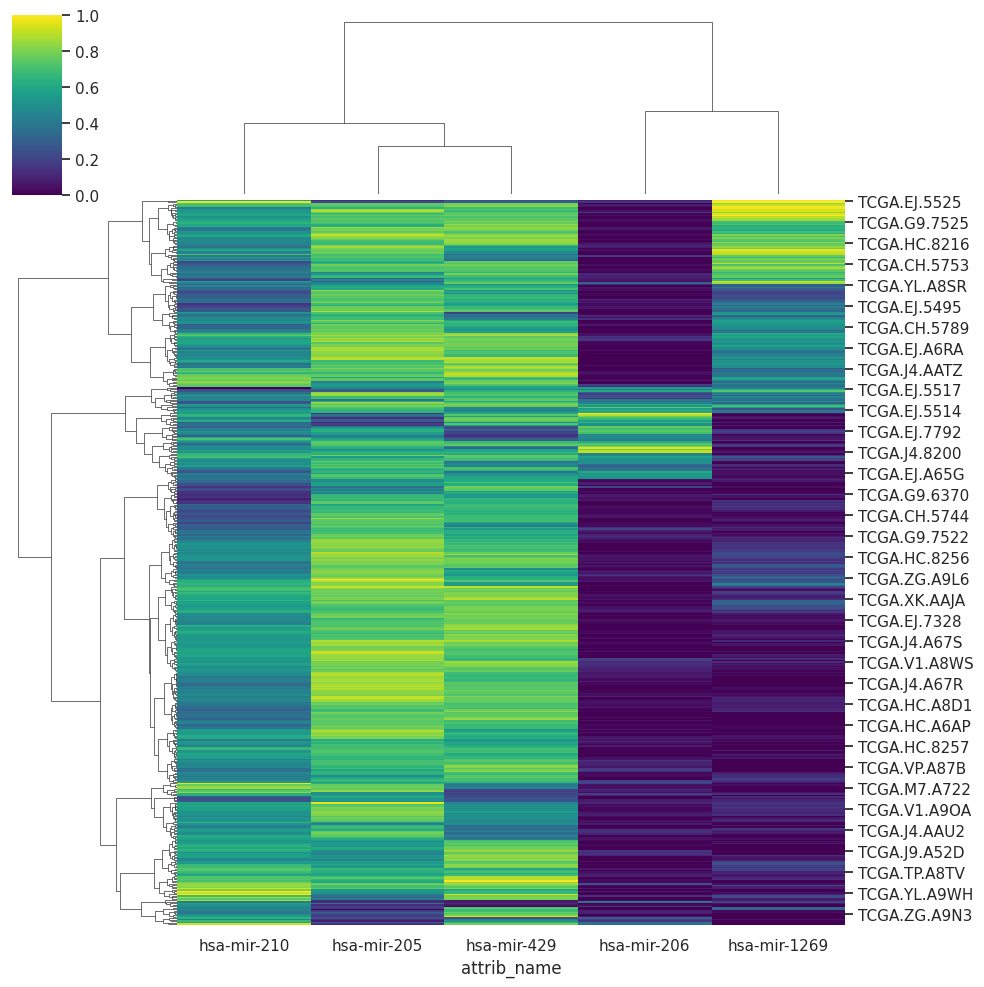

In [ ]:
sns.clustermap(merged_data[selected_mirnas], metric='euclidean', method='ward', cmap='viridis', standard_scale=1)
plt.show()

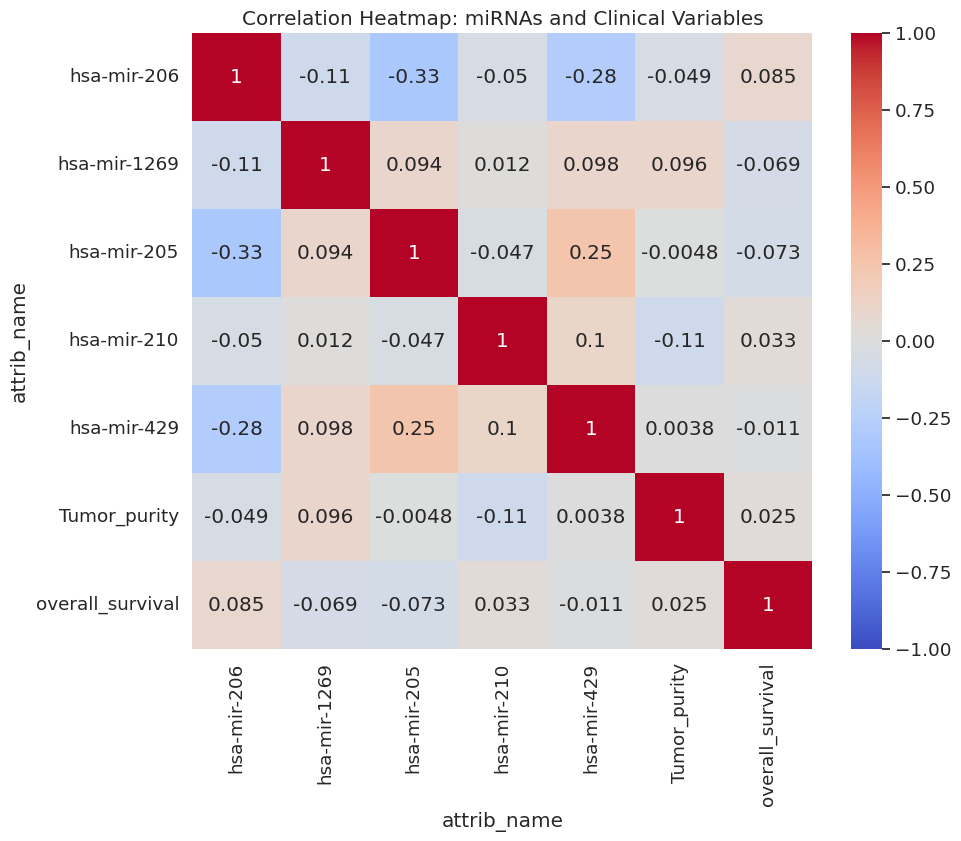

In [ ]:
# Plot 4: Heatmap of correlations between miRNAs and clinical variables
numeric_data = merged_data[selected_mirnas.tolist() + ['Tumor_purity', 'overall_survival']].dropna()
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: miRNAs and Clinical Variables')
plt.show()